---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np

# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import pandas as pd

train_data = pd.read_csv("signnames.csv")


assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

n_train = np.shape(X_train)[0]

# TODO: Number of validation examples
n_validation = np.shape(X_valid)[0]

# TODO: Number of testing examples.
n_test = np.shape(X_test)[0]

# TODO: What's the shape of an traffic sign image?
#image_shape = np.shape(train['features'][0][0])
image_shape = np.shape(train['features'])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.shape(train['labels'])

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Shape of the traffic sign image: ", image_shape)
print("Number of classes =", len(train_data))

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Shape of the traffic sign image:  (34799, 32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

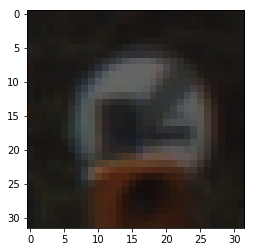

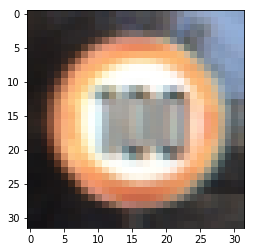

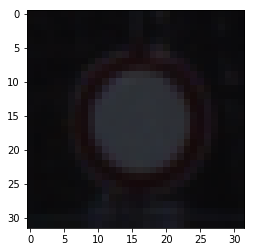

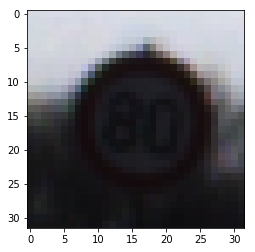

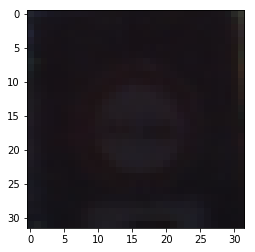

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
for i in range(5):
    rand = np.random.randint(n_train)
    plt.imshow(X_train[rand])
    plt.show()

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

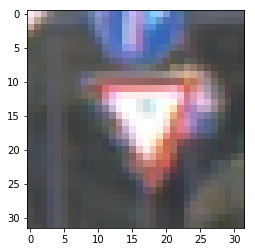

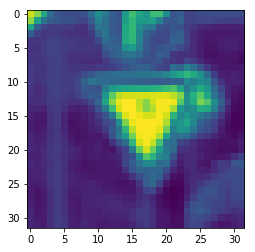

100%|██████████| 32/32 [00:00<00:00, 2959.53it/s]

Applying Gaussian Blur ..


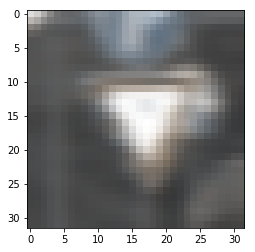

In [4]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

# grayscale conversion
from tqdm import tqdm
import cv2

# image normalization by converting to grayscale

def convert_to_gray(data):
    print("Converting to grayscale ..")
    result = []
    for i in tqdm(range(len(data))):
        result.append(cv2.cvtColor(data[i], cv2.COLOR_RGB2GRAY))
    return np.reshape(result,(len(data), 32, 32, 1))

# apply gaussian blur

def gaussian_blur(data):
    print("Applying Gaussian Blur ..")
    result = []
    for i in tqdm(range(len(data))):
        result.append(cv2.GaussianBlur(data[i], (5,5), 0))
        
    return result

rnd = np.random.randint(0, n_train)
img = X_train[rnd]
plt.imshow(img)
plt.show() 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
plt.show()
plt.imshow(gaussian_blur(img))
plt.show() 

# Apply gamma correction

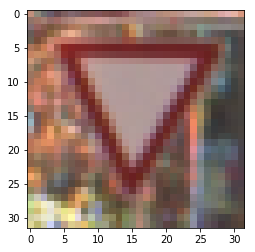

100%|██████████| 32/32 [00:00<00:00, 993.89it/s]

Applying Gamma correction ..


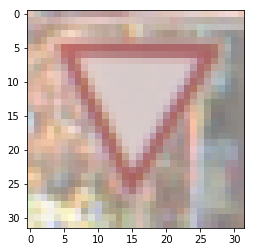

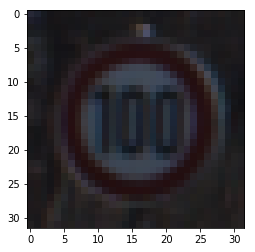

100%|██████████| 32/32 [00:00<00:00, 1017.97it/s]

Applying Gamma correction ..


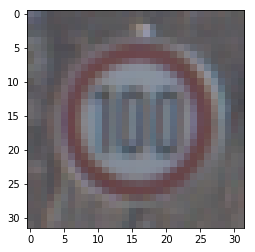

In [5]:
def adjust_gamma(data, gamma=1.0):
    print("Applying Gamma correction ..")
    result = []
    for j in tqdm(range(len(data))):
        # build a lookup table mapping the pixel values [0, 255] to
        # their adjusted gamma values
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255
            for i in np.arange(0, 256)]).astype("uint8")

        # apply gamma correction using the lookup table
        result.append(cv2.LUT(data[j], table))
        table = []
    return result

# test out on 2 random images
for i in range(2):
    rnd = np.random.randint(0, len(X_train))
    img = X_train[rnd]
    plt.imshow(img)
    plt.show() 
    gamma_corrected = adjust_gamma(img, 2.2)
    plt.imshow(gamma_corrected)
    plt.show()


In [6]:

# Rotate the image by an angle
#the routine below will work on grayscale images only
def rotation(data, angle):
    print("Rotating ..")
    result = []
    for i in tqdm(range(len(data))):
        img = np.reshape(data[i],(32,32,1))
        rows, cols ,channels = np.shape(img)
        rot_mat = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1.0)
        dst = cv2.warpAffine(img,rot_mat,(cols,rows))
        result.append(dst)
    return np.reshape(result, (len(result),32,32,1))

In [7]:
#image normalization by averaging

def normalize(data):
    # define local variables
    print("Normalizing ..")
    result = []
    second_axis = []
    first_axis = []
    # iterate through entire training set
    for i in tqdm(range(len(data))):
        # iterate through all rows
        for j in range(len(data[0])):
            # iterate through all columns
            for k in range(len(data[0][0])):
                # normalize 
                result.append(((data[i][j][k]/255.0) - 0.5))
            # fill up the row dimension
            second_axis.append(result) 
            #flush data
            result = []
        # fill up the training set dimension
        first_axis.append(second_axis) 
        #flush data
        second_axis = []
        
    return first_axis


## Data Preprocessing

In [8]:
# apply preprocessing to training dataset
# 1. Blur image
# 2. convert to grayscale
# 3. normalize
# 4. gamma correct

def data_preprocessing(X_data):
    X_processed = gaussian_blur(X_data)
    X_processed = convert_to_gray(X_processed)
    X_processed = adjust_gamma(X_processed, 2.2)
    X_processed = normalize(X_processed)
    
    return np.reshape(X_processed,(len(X_processed), 32, 32, 1))




## Dataset Augmentation

In [9]:

def augmented_dataset(X_data, y_data):
    # create empty arrays for augmenting dataset
    X_rotated_left = []
    y_rotated_left = []

    X_rotated_right = []
    y_rotated_right = []
    
    X_rotated_left = rotation(X_data, 10)
    y_rotated_left = y_data
    
    X_rotated_right = rotation(X_data, -10)
    y_rotated_right = y_data
    
    return (np.concatenate((X_data, X_rotated_left, X_rotated_right)),np.concatenate((y_data, y_rotated_left, y_rotated_right))) 



### Model Architecture

In [10]:
### Define your architecture here.


import tensorflow as tf
from tensorflow.contrib.layers import flatten


EPOCHS = 30
BATCH_SIZE = 128

def LeNet(x):    

    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. The output shape should be 28x28x6
    
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, keep_prob)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #  Activation.
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return [logits, conv1_W, conv2_W, fc1_W, fc2_W, fc3_W]
    

Features and Labels

In [11]:
import pandas as pd

train_data = pd.read_csv("signnames.csv")

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, len(train_data))

### Augment and preprocess the datasets

In [12]:
X_augmented, y_augmented = augmented_dataset(data_preprocessing(X_train), y_train)

X_valid = data_preprocessing(X_valid)
X_test = data_preprocessing(X_test)

 12%|█▏        | 4035/34799 [00:00<00:00, 40342.92it/s]

Applying Gaussian Blur ..


 32%|███▏      | 11292/34799 [00:00<00:00, 112907.99it/s]

Converting to grayscale ..


  0%|          | 106/34799 [00:00<00:33, 1050.44it/s]

Applying Gamma correction ..


  0%|          | 24/34799 [00:00<02:29, 233.19it/s]

Normalizing ..


  7%|▋         | 2561/34799 [00:00<00:01, 25599.71it/s]

Rotating ..


  8%|▊         | 2647/34799 [00:00<00:01, 26466.05it/s]

Rotating ..


  0%|          | 0/4410 [00:00<?, ?it/s]

Applying Gaussian Blur ..
Converting to grayscale ..
Applying Gamma correction ..


  1%|          | 24/4410 [00:00<00:18, 235.41it/s]

Normalizing ..


 35%|███▌      | 4466/12630 [00:00<00:00, 44651.63it/s]

Applying Gaussian Blur ..


  0%|          | 0/12630 [00:00<?, ?it/s]

Converting to grayscale ..
Applying Gamma correction ..


  0%|          | 24/12630 [00:00<00:54, 231.64it/s]

Normalizing ..


100%|██████████| 12630/12630 [00:55<00:00, 227.90it/s]


### Pickle the augmented dataset

In [13]:

with open("train_augmented.p", 'wb') as f:
    pickle.dump((X_augmented, y_augmented),f)

with open("valid_processed.p", 'wb') as f:
    pickle.dump((X_valid, y_valid), f)

with open("test_processed.p", 'wb') as f:
    pickle.dump((X_test, y_test), f)

### Unpickle the augmented dataset files

In [14]:
import pickle
import numpy as np

training_file = "train_augmented.p"
validation_file= "valid_processed.p"
testing_file = "test_processed.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train[0], train[1]
X_valid, y_valid = valid[0], valid[1]
X_test, y_test = test[0], test[1]

### Train, Validate and Test the Model

In [15]:
### Training pipeline

rate = 0.001
reg_constant = 0.0005

[logits, conv1_W, conv2_W, fc1_W, fc2_W, fc3_W] = LeNet(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

regularizer = tf.nn.l2_loss(conv1_W) + tf.nn.l2_loss(conv2_W) + tf.nn.l2_loss(fc1_W) + tf.nn.l2_loss(fc2_W) + tf.nn.l2_loss(fc3_W)

loss_operation = tf.reduce_mean(cross_entropy + reg_constant * regularizer)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)

training_operation = optimizer.minimize(loss_operation)


In [16]:
# Accuracy calculations

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [17]:
# Training commands

# Shuffle training set

from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_augmented, y_augmented = shuffle(X_train, y_train)
        
        for offset in tqdm(range(0, num_examples, BATCH_SIZE)):
            end = offset + BATCH_SIZE
            batch_x, batch_y = np.reshape(X_augmented[offset:end], (len(X_augmented[offset:end]), 32, 32 ,1)), y_augmented[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.75})
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    
    testing_accuracy = sess.run(accuracy_operation, feed_dict={x: X_test, y: y_test, keep_prob: 1.0})
    print("testing accuracy = {:.3f}".format(testing_accuracy))
    
    saver.save(sess, './lenet')
    print("Model saved")

Training...



100%|██████████| 816/816 [00:08<00:00, 92.64it/s] 


EPOCH 1 ...
Validation Accuracy = 0.748



100%|██████████| 816/816 [00:07<00:00, 114.02it/s]


EPOCH 2 ...
Validation Accuracy = 0.855



100%|██████████| 816/816 [00:07<00:00, 114.00it/s]


EPOCH 3 ...
Validation Accuracy = 0.893



100%|██████████| 816/816 [00:07<00:00, 114.14it/s]


EPOCH 4 ...
Validation Accuracy = 0.925



100%|██████████| 816/816 [00:07<00:00, 114.19it/s]


EPOCH 5 ...
Validation Accuracy = 0.944



100%|██████████| 816/816 [00:07<00:00, 114.09it/s]


EPOCH 6 ...
Validation Accuracy = 0.942



100%|██████████| 816/816 [00:07<00:00, 113.97it/s]


EPOCH 7 ...
Validation Accuracy = 0.947



100%|██████████| 816/816 [00:07<00:00, 113.40it/s]


EPOCH 8 ...
Validation Accuracy = 0.955



100%|██████████| 816/816 [00:07<00:00, 114.06it/s]


EPOCH 9 ...
Validation Accuracy = 0.958



100%|██████████| 816/816 [00:07<00:00, 114.45it/s]


EPOCH 10 ...
Validation Accuracy = 0.949



100%|██████████| 816/816 [00:07<00:00, 113.82it/s]


EPOCH 11 ...
Validation Accuracy = 0.947



100%|██████████| 816/816 [00:07<00:00, 114.03it/s]


EPOCH 12 ...
Validation Accuracy = 0.943



100%|██████████| 816/816 [00:07<00:00, 113.50it/s]


EPOCH 13 ...
Validation Accuracy = 0.956



100%|██████████| 816/816 [00:07<00:00, 114.23it/s]


EPOCH 14 ...
Validation Accuracy = 0.946



100%|██████████| 816/816 [00:07<00:00, 114.06it/s]


EPOCH 15 ...
Validation Accuracy = 0.958



100%|██████████| 816/816 [00:07<00:00, 113.92it/s]


EPOCH 16 ...
Validation Accuracy = 0.953



100%|██████████| 816/816 [00:07<00:00, 113.95it/s]


EPOCH 17 ...
Validation Accuracy = 0.956



100%|██████████| 816/816 [00:07<00:00, 114.13it/s]


EPOCH 18 ...
Validation Accuracy = 0.962



100%|██████████| 816/816 [00:07<00:00, 113.94it/s]


EPOCH 19 ...
Validation Accuracy = 0.955



100%|██████████| 816/816 [00:07<00:00, 114.20it/s]


EPOCH 20 ...
Validation Accuracy = 0.956



100%|██████████| 816/816 [00:07<00:00, 114.15it/s]


EPOCH 21 ...
Validation Accuracy = 0.958



100%|██████████| 816/816 [00:07<00:00, 114.18it/s]


EPOCH 22 ...
Validation Accuracy = 0.953



100%|██████████| 816/816 [00:07<00:00, 113.13it/s]


EPOCH 23 ...
Validation Accuracy = 0.966



100%|██████████| 816/816 [00:07<00:00, 114.06it/s]


EPOCH 24 ...
Validation Accuracy = 0.959



100%|██████████| 816/816 [00:07<00:00, 114.15it/s]


EPOCH 25 ...
Validation Accuracy = 0.959



100%|██████████| 816/816 [00:07<00:00, 114.34it/s]


EPOCH 26 ...
Validation Accuracy = 0.959



100%|██████████| 816/816 [00:07<00:00, 114.24it/s]


EPOCH 27 ...
Validation Accuracy = 0.962



100%|██████████| 816/816 [00:07<00:00, 113.60it/s]


EPOCH 28 ...
Validation Accuracy = 0.955



100%|██████████| 816/816 [00:07<00:00, 114.09it/s]


EPOCH 29 ...
Validation Accuracy = 0.951



100%|██████████| 816/816 [00:07<00:00, 113.93it/s]


EPOCH 30 ...
Validation Accuracy = 0.966

testing accuracy = 0.947
Model saved


A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

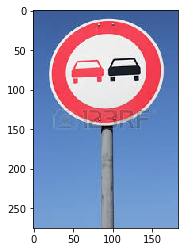

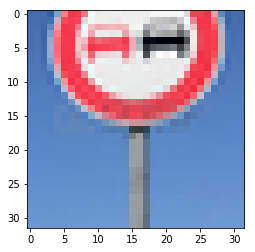

(32, 32, 3)
(32, 32, 3)
(1, 32, 32, 3)


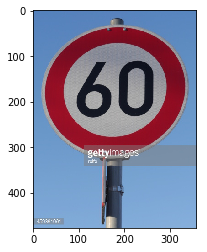

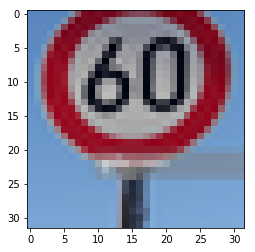

(32, 32, 3)
(32, 32, 3)
(2, 32, 32, 3)


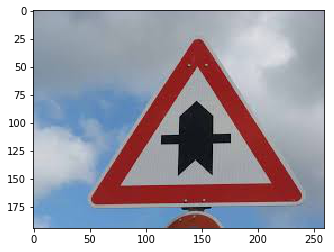

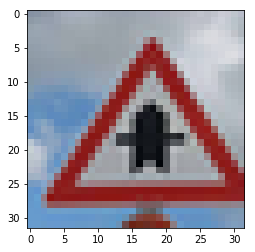

(32, 32, 3)
(32, 32, 3)
(3, 32, 32, 3)


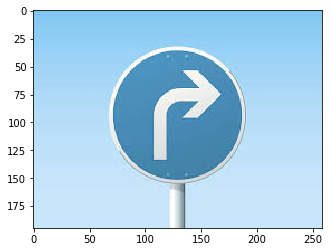

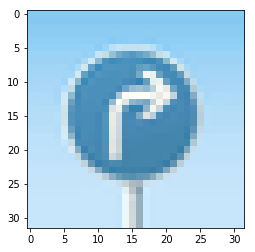

(32, 32, 3)
(32, 32, 3)
(4, 32, 32, 3)


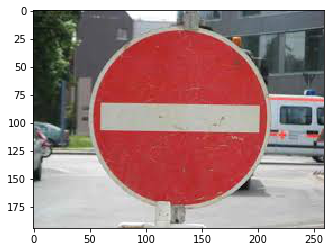

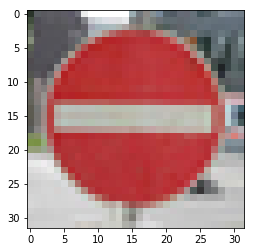

(32, 32, 3)
(32, 32, 3)
(5, 32, 32, 3)


IsADirectoryError: [Errno 21] Is a directory: 'test-set/processed-image'

In [19]:
### Load the images and plot them here.
import os
import matplotlib.image as mpimg
from PIL import Image
from resizeimage import resizeimage
import matplotlib.pyplot as plt
import numpy as np

test_set = []
test_images_path = "test-set/"
test_images = os.listdir(test_images_path)

i=0
for image in test_images:
    with open(test_images_path+image, 'r+b') as f:
        with Image.open(f) as test_image:
            plt.imshow(test_image)
            plt.show()
            cover = resizeimage.resize_cover(test_image, (32, 32, 3))
            plt.imshow(cover)
            plt.show()
            cover.save(test_images_path+'processed-image/'+image, test_image.format)
            print(np.shape(cover))
            test_set.append(np.copy(cover))
            print(np.shape(test_set[i]))
    i+=1
    print(np.shape(test_set))


## Preprocess new images

In [20]:
test_set = data_preprocessing(test_set)


100%|██████████| 5/5 [00:00<00:00, 230.87it/s]

Applying Gaussian Blur ..
Converting to grayscale ..
Applying Gamma correction ..
Normalizing ..


### Predict the Sign Type for Each Image

In [21]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
import tensorflow as tf
with tf.Session() as sess:
    saver.restore(sess,'./lenet')
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    predicted_logits=sess.run(logits,feed_dict={x:test_set, keep_prob: 1})
    predicted_prob=sess.run(tf.nn.softmax(predicted_logits))
    predicted_labels = np.argmax(predicted_logits, axis=1)
    print(predicted_labels)
    top_5 = sess.run(tf.nn.top_k(tf.constant(predicted_prob), k=5))
    print(top_5)

[13 17 11 33 17]
TopKV2(values=array([[  3.47598106e-01,   3.42316151e-01,   1.13081470e-01,
          4.34648134e-02,   3.53232622e-02],
       [  9.63022649e-01,   2.93264631e-02,   3.56917968e-03,
          3.34655144e-03,   2.04151453e-04],
       [  9.99995112e-01,   4.07309972e-06,   3.83374697e-07,
          2.19449035e-07,   1.74959197e-07],
       [  9.95784342e-01,   1.41614873e-03,   1.38310296e-03,
          7.99319067e-04,   1.25581064e-04],
       [  9.99989510e-01,   4.56233920e-06,   3.67223743e-06,
          1.43886984e-06,   3.08305943e-07]], dtype=float32), indices=array([[13, 12,  1,  7, 11],
       [17,  9, 40, 41, 38],
       [11, 30, 21, 23, 40],
       [33, 11, 35, 40,  1],
       [17, 14, 34, 41,  9]], dtype=int32))


### Analyze Performance

In [22]:
### Accuracy for these 5 new images

print(predicted_labels)
new_images_accuracy = []
for i in range(len(test_set)):
    new_images_accuracy.append(np.max(predicted_prob[i]))
    print("Accuracy of image ",i, ":", new_images_accuracy[i])

print("Average Accuracy = ",np.mean(new_images_accuracy))



[13 17 11 33 17]
Accuracy of image  0 : 0.347598
Accuracy of image  1 : 0.963023
Accuracy of image  2 : 0.999995
Accuracy of image  3 : 0.995784
Accuracy of image  4 : 0.99999
Average Accuracy =  0.861278
